<a href="https://colab.research.google.com/github/Hiagod/gprc/blob/master/gpcr-back/MobileNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



#Importação de Bibliotecas


In [ ]:
!pip install opencv-python



In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential



In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Carregamento e Pré-processamento dos Dados

In [ ]:
data_dir = '/content/drive/MyDrive/TCC/mobile_phone_dataset'

# Definir parâmetros para carregamento de imagens e data augmentation
batch_size = 32
img_height = 224
img_width = 224

# Usar ImageDataGenerator para carregar e pré-processar as imagens
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2  # dividir automaticamente em conjuntos de treinamento e validação
)

# Carregar imagens de treinamento e validação do diretório
train_data = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # especificar que queremos os dados de treinamento
)

val_data = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # especificar que queremos os dados de validação
)


Found 1012 images belonging to 50 classes.
Found 205 images belonging to 50 classes.


#Definição e Treinamento do Modelo

In [ ]:
base_model = tf.keras.applications.MobileNet(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet'
)

# Congelar as camadas do modelo base
base_model.trainable = False

# Adicionar camadas adicionais no topo do modelo
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(train_data.num_classes, activation='softmax')
])

# Compilar o modelo
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Treinar o modelo
epochs = 20
history = model.fit(
    train_data,
    epochs=epochs,
    validation_data=val_data
)

17225924/17225924 [==============================] - 0s 0us/step
Epoch 1/20
32/32 [==============================] - 348s 11s/step - loss: 3.8385 - accuracy: 0.0751 - val_loss: 3.1520 - val_accuracy: 0.3220
Epoch 2/20
32/32 [==============================] - 21s 652ms/step - loss: 2.8513 - accuracy: 0.2727 - val_loss: 2.1747 - val_accuracy: 0.6537
Epoch 3/20
32/32 [==============================] - 21s 650ms/step - loss: 2.1300 - accuracy: 0.4684 - val_loss: 1.5732 - val_accuracy: 0.7707
Epoch 4/20
32/32 [==============================] - 20s 633ms/step - loss: 1.5851 - accuracy: 0.6038 - val_loss: 1.0714 - val_accuracy: 0.8927
Epoch 5/20
32/32 [==============================] - 21s 664ms/step - loss: 1.2314 - accuracy: 0.6966 - val_loss: 0.8634 - val_accuracy: 0.9220
Epoch 6/20
32/32 [==============================] - 22s 691ms/step - loss: 0.9549 - accuracy: 0.7638 - val_loss: 0.6296 - val_accuracy: 0.9268
Epoch 7/20
32/32 [==============================] - 20s 630ms/step - loss: 0.7

#Avaliação do Modelo e Visualização dos Resultados

Última precisão de treinamento: 97.13%
Última precisão de validação: 97.07%


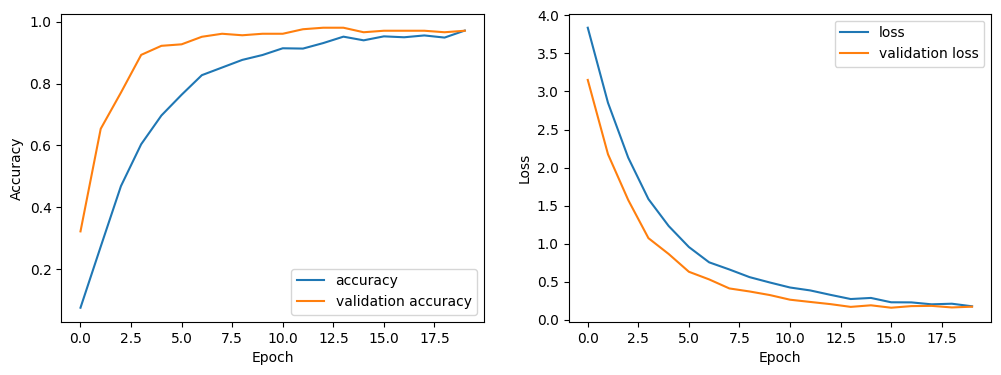

In [ ]:
# Plotar curvas de aprendizado
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

final_train_accuracy = train_accuracy[-1]
final_val_accuracy = val_accuracy[-1]

print(f"Última precisão de treinamento: {final_train_accuracy * 100:.2f}%")
print(f"Última precisão de validação: {final_val_accuracy * 100:.2f}%")

plt.show()

In [ ]:
# Fazer previsões para os dados de validação
y_val_true = np.concatenate([val_data[i][1] for i in range(len(val_data))])
y_val_true = np.argmax(y_val_true, axis=1)

y_val_prob = model.predict(val_data)
y_val_pred = np.argmax(y_val_prob, axis=1)




7/7 [==============================] - 4s 607ms/step


In [ ]:
from sklearn.metrics import classification_report
class_labels = list(train_data.class_indices.keys())

# Calcular as métricas de classificação para os dados de validação
report = classification_report(y_val_true, y_val_pred, target_names=class_labels, output_dict=True)

# Extrair apenas as métricas desejadas
metrics_dict = {
    'Acurácia': report['accuracy'],
    'Média Macro': report['macro avg'],
    'Média Ponderada': report['weighted avg']
}

# Criar DataFrame a partir das métricas extraídas
metrics_df = pd.DataFrame(metrics_dict).transpose()

# Exibir a tabela com as métricas específicas
print("\nTabela de Métricas Específicas do Modelo (Dados de Validação):")
print(metrics_df.to_markdown())





Tabela de Métricas Específicas do Modelo (Dados de Validação):
|                 |   precision |   recall |   f1-score |    support |
|:----------------|------------:|---------:|-----------:|-----------:|
| Acurácia        |    0.970732 | 0.970732 |   0.970732 |   0.970732 |
| Média Macro     |    0.975    | 0.97     |   0.969286 | 205        |
| Média Ponderada |    0.97561  | 0.970732 |   0.970035 | 205        |


#Salvar o modelo

In [ ]:
saved_model_path = '/content/drive/MyDrive/TCC/Modelo_MobileNet'

# Salvar o modelo treinado no diretório especificado
model.save(saved_model_path)

print(f"Modelo salvo com sucesso em: {saved_model_path}")


Modelo salvo com sucesso em: /content/drive/MyDrive/TCC/Modelo_MobileNet


In [ ]:
from tensorflow.keras.preprocessing import image

def load_and_preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalizar
    return img_array

#Detecção de Rosto na Imagem

In [ ]:
# Carregar o classificador Haar Cascade para detecção de rosto
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

#Utilizar a Função de Autenticação com Detecção de Rosto

In [ ]:
def detect_face(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detectar rostos na imagem
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Se nenhum rosto for detectado
    if len(faces) == 0:
        return None, None  # Retorna None se nenhum rosto for detectado

    # Desenhar retângulo ao redor do rosto detectado na imagem original
    for (x, y, w, h) in faces:
        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)  # Desenha retângulo azul ao redor do rosto

    # Extrair a área do rosto (supondo que haja apenas um rosto na imagem)
    (x, y, w, h) = faces[0]
    face_roi = img[y:y+h, x:x+w]

    return img, face_roi

In [ ]:
def authenticate_person(model, image_path, true_person):
    img_array = load_and_preprocess_image(image_path)
    prediction = model.predict(img_array)

    # Obter os rótulos das classes do gerador de dados
    class_labels = list(train_data.class_indices.keys())

    # Encontrar o índice da classe predita com maior probabilidade
    predicted_index = np.argmax(prediction)

    # Obter o nome da classe predita usando o índice
    predicted_person = class_labels[predicted_index]

    return predicted_person == true_person


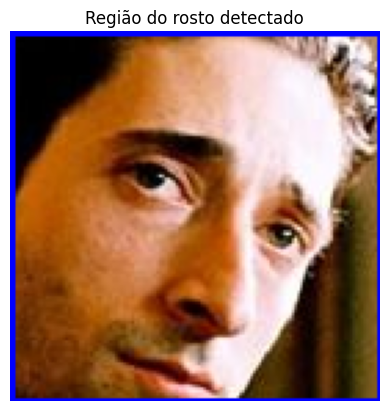

In [ ]:
image_path = '/content/drive/MyDrive/TCC/fotos_hiago_teste_manual/119210326/Adrien Brody.JPG'
img_with_face_rect, face_roi = detect_face(image_path)

if img_with_face_rect is not None:

    # Exibir a região do rosto detectado
    plt.imshow(cv2.cvtColor(face_roi, cv2.COLOR_BGR2RGB))
    plt.title('Região do rosto detectado')
    plt.axis('off')
    plt.show()
else:
    print('Nenhum rosto foi detectado nesta imagem.')

In [ ]:
true_person = '11_hp_norasela'

is_authenticated = authenticate_person(model, image_path, true_person)
print(is_authenticated)

1/1 [==============================] - 1s 949ms/step
True


#Adição de Novas Pessoas

In [ ]:
def preprocess_image_with_face_detection(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detectar rostos na imagem
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Verificar se algum rosto foi detectado
    if len(faces) > 0:
        # Extrair a área do primeiro rosto detectado (supondo apenas um rosto por imagem)
        (x, y, w, h) = faces[0]
        face_roi = img[y:y+h, x:x+w]

        # Redimensionar a região do rosto para o tamanho desejado (por exemplo, 224x224)
        face_roi_resized = cv2.resize(face_roi, (img_height, img_width))

        # Normalizar os pixels da imagem para valores entre 0 e 1
        face_roi_normalized = face_roi_resized / 255.0

        return face_roi_normalized
    else:
        return None


In [ ]:
new_data_dir = '/content/drive/MyDrive/TCC/fotos_hiago'
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

batch_size = 8
img_height = 224
img_width = 224

# Criar novo ImageDataGenerator com data augmentation para o conjunto expandido de dados
train_datagen_new = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2  # dividir automaticamente em conjuntos de treinamento e validação
)


# Carregar imagens de treinamento e validação do novo diretório
train_data_new = train_datagen_new.flow_from_directory(
    new_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # especificar que queremos os dados de treinamento
)

val_data_new = train_datagen_new.flow_from_directory(
    new_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # especificar que queremos os dados de validação
)



Found 13 images belonging to 1 classes.
Found 3 images belonging to 1 classes.


In [ ]:
combined_train_data = np.concatenate([train_data, train_data_new])
combined_val_data = np.concatenate([val_data, val_data_new])
epochs = 20



NameError: name 'np' is not defined

In [ ]:
history_new = model.fit(
    combined_train_data,
    epochs=epochs,
    validation_data=combined_val_data
)

NameError: name 'model' is not defined

In [ ]:
# Plotar curvas de aprendizado
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_new.history['accuracy'], label='accuracy')
plt.plot(history_new.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_new.history['loss'], label='loss')
plt.plot(history_new.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

train_accuracy = history_new.history['accuracy']
val_accuracy = history_new.history['val_accuracy']

final_train_accuracy = train_accuracy[-1]
final_val_accuracy = val_accuracy[-1]

print(f"Última precisão de treinamento: {final_train_accuracy * 100:.2f}%")
print(f"Última precisão de validação: {final_val_accuracy * 100:.2f}%")

plt.show()